**Advanced Math Tutor**

Since we are dealing with RAG task I started with collecting relevant documents. I downloaded different textbooks for both algebra and math for grades 6-11, ZNO preparation textbook, calculus/linalg book as well.

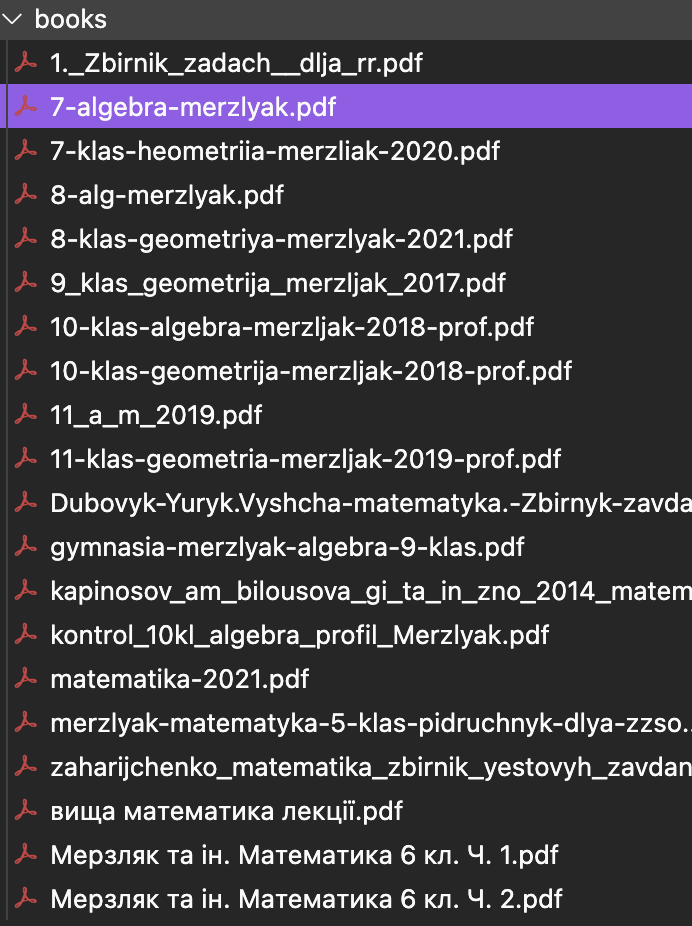

Then I needed to convert this files into text. I wanted to use LLamaParse, but it had limits on usage, so I ended up with marker, since it tries to presenve headers, lists, tables, math in general in markdown format.

In `part_1_parsing.py` we just load pdfs, one per time, preprocess it, save results (text/images). the result is list of parsed documents

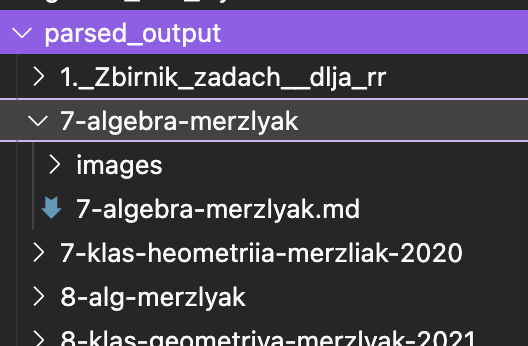

But it turned out that most of the resulted texts (maybe due to files being quite old) have one particular issue - wrong encoding or offset. In `part_2_cleaning_parsed_data.py` I tried to fix those issues. like converting from win1252 encoding into win1251, bad font mapping, visual clutter, etc. As the result we overwrite files with fixed texts

Now, as we have parsed and cleaned data, we need to split it into smaller parts.

In `part_3_splitting.py` I implemented several approaches to chunking data: math-aware, semantic, hybrid. math-aware performs splits in math related places, like proofs, theorems, headers, avoids splits across them. Semantic spliting was tried to use to achieve better and more coheremnt embeddings, but turned out to be unstable. Hybrid approach was used that separated on header level with some additional large-chunk spliting logic. Resulted chunks have to be moderate size as we will put them into context of agents

As the result, we get `chunks.json`

Now, as we have splitted data, we need to put it in some index for fast retrieval. Currently, de facto standard is usage of vector database or document store/index to be precise.

I have previously worked with faiss and for the sake of new experience decided to try something else, thus choosing Chroma. It is neither better, nor worse, though in our use case maybe even better, since I am not using gpu for speed up. Chroma provides persistent storage, metadata for chunks, easy rebuilding, works well out of the box and performs normalization itself. Though it is not much more work with faiss and it is more familiar to me, but I deceided to try something new

In `part_4_vector_db.py` I builded persistent chroma vector database. As the result index in `/vector_store/` was created

Another required step is the creation of validation dataset. 

Agents are quite easily able to solve basic math issues, thus we needed something more complicated. Firstly, there was an idea to simply generate tasks. While it is fast and easy way It was promptly dismissed as if model was able to generate and solve it, then our agent solution would be able to do same as it probably was somethere in internet.

Secondly, I tried using retrieved context to form tasks. But new issue emerged - there was 100% accuracy. It turned out that model generated such tasks that were mostly solved or existed freely in internet. I tried to tackle it with prompting, explicitly forbiding to take solved tasks, but it either did not work or just tasks themselves were quite easy.

Thirdly, I used existing Kapinosov ZNO preparation textbook, searched for tasks without `black_square` tag (it means that it is an example), took tasks with higher numbers as they usually are more complicated, used agent to extract the task (since it captures either different tasks or some unnecessary tags), used other 3 agents to make solving consensus (using another as judge) and form the dataset. I also manually added a few tasks from old text book on calculus and linalg. Described approach is in `part_5_evaluation_dataset_generation.py`

The next step is baseline creation. The most obvious baseline is usage of single agent without any tools/approaches. The second thing we need to ensure is that retrieval actually helps in solving tasks. Thus, the second approach is usage of single agent with context from RAG. Those approaches are implemented in `part_6_base_systems.py`

Third approach is multi-agent system. In it we utilize multiple agents, each with separate role to perform. Amount of agents is based on particular nodes in the architecture. I played with different architectures, starting with small amount of nodes and complex task per agent, but it did not work well, probably due to large amount of information per request. Thus, I came up with the next architecture:

Analyze -> Retrieve -> Solution -> Verify
                           |
                         Refine
                           |
                         Finalize

- Analyze node has a job of interpreting the user's intent, identifying key parts of question and constructing math expression for wolfram
- Retrieve node retrieves relevant content. It takes question and the key concepts identified in the previous step to search vector database
- Solution node generates solution for question based on context
- Verify verifies math with wolfram
- Refine is error correcting agent if verification failed

It is implemented using LangGraph. Given nodes form a directional graph. They all share state which they read and which they write to

It is implemented in `part_7_multi_agent_system.py`

The final step is evaluation. To properly evaluate outputs we need to use another model to evaluate if the results are similar, same, or not; since generated outputs can have different forms, as llms are generative models. Thus I introduced LLM judge, whose only job is to compare results.

In evaluation loop, for each sample from evaluation dataset we call solver, judge it, measure metrics and time, collect logs. Do this for each of methods. It is implemented in `part_8_evaluation.py`

Final results are:

<pre>
final comparison
baseline (no rag)    | accuracy:  46.81% | avg time:   8.50s
rag                  | accuracy:  40.43% | avg time:   8.38s
multi-agent          | accuracy:  48.94% | avg time:  69.85s
</pre>

Multi-agent approach has the best accuracy, but 8 times slower. 

RAG was outperformed by baseline due to the fact that retrived context did not really get useful information, but only produced noise. Tasks were short and well formed and backbone model already knew how to perform it. when we introduce retrieved context, it overconstrains reasoning and maybe introduces wrong sections. Thus we can make a conclusion that wrong context is worse in math than no context.

also the issue might be that retrieval is mostly lexical based, not math based. we retrieve most similar topic, not exact method or useful example. model might believe context and apply wrong template

Multi-agent approach wins maybe due to the fact that: it uses wolfram check; it forces correction when mismatch detected; and numeric grounding

My guess is the gain is limited due to baseline being really good. Also verification could not help if math_expression was wrong.


Time is easier. For multi-agent approach we make calls to LLM multiple times and call Wolfram as well


The architecture is not perfect, it could benefit from better judge (that checks not just result, but solving as well), better dataset creation (maybe the main issue are the tasks themselves are not good enough). Also it would be beneficial to try worse models, like gemma3 that are not that good and such retrieval might actually benefit. I would have tried doing this, but I caught cold on Christmas and already after deadline, so I reserve it to try out in the future (did not make notebook as wolfram api had issue there, so i ran regular scripts)